# DeepSeek OCR Pipeline - Google Cloud Run GPU

This notebook runs a three-stage OCR pipeline on Google Cloud Run with GPU support:

1. **Extract** - Run DeepSeek OCR over a dataset, save Markdown and crop detected figures
2. **Describe** - Generate captions for extracted figures  
3. **Assemble** - Enrich Markdown with figure captions

All three stages write a **Hugging Face dataset** to GCS. Each stage pulls the current dataset, adds new columns with its outputs, and saves the updated dataset back, so by the end you have one dataset with all intermediate and final results.

**Prerequisites:**
- Google Cloud credentials configured
- Cloud Run GPU enabled in your project
- Required packages: `google-cloud-run`, `google-cloud-storage`

**References:**
- [Cloud Run GPU Documentation](https://cloud.google.com/run/docs/configuring/services/gpu)
- [Cloud Run Pricing](https://cloud.google.com/run/pricing)


## 📑 Table of Contents

1. [Setup](#setup)
   - [Google Cloud Run](#cloud-run)
   - [How the pipeline code is shipped](#code-shipping)
   - [The dataset](#dataset)
   - [Inference Backend: vLLM](#vllm-backend)
   - [DeepSeek-OCR Prompts](#prompts)
   - [Authentication](#authentication)
2. [Configuration](#configuration)
3. [Create GCS Bucket](#gcs-bucket)
4. [Build Container Image](#build-container)
5. [Helper Functions](#helpers)
6. [Stage 1: Extract](#stage-1)
   - [Batch size optimization](#batch-size)
7. [Stage 2: Describe](#stage-2)
8. [Stage 3: Assemble](#stage-3)
9. [Cost Analysis](#cost-analysis)
10. [Cleanup](#cleanup)


<a id="setup"></a>
## ⚙️ Setup

<a id="cloud-run"></a>
### ☁️ Google Cloud Run

[Cloud Run](https://cloud.google.com/run) is a fully managed serverless platform that automatically scales containers. With [GPU support](https://cloud.google.com/run/docs/configuring/services/gpu), you can run ML inference workloads without managing infrastructure.

**Key features for this pipeline:**
- **L4 GPUs**: 24GB VRAM, good for 7B parameter models
- **Pay per use**: billed per second while the job runs
- **Auto-scaling**:  scales to zero when idle
- **Container-based**: package your code + dependencies in a Docker image


<a id="code-shipping"></a>
### 📦 How the pipeline code is shipped

For every Cloud Run Job we launch, the logic is similar:

**From this notebook**, we build a Docker image containing:
1. The entrypoint script (`cloudrun_job_runner.py`)
2. The pipeline code in `llm_ocr/`

The image is pushed to Google Artifact Registry.

**Then we launch a Cloud Run Job** that pulls the Docker image and runs it. The job:
1. Starts a vLLM server with DeepSeek-OCR model
2. Imports `llm_ocr.cli` and calls `main()` to run the requested pipeline stage
3. Saves results to GCS (Google Cloud Storage)


<a id="dataset"></a>
### 📚 The dataset

This pipeline uses **FineVision** (`HuggingFaceM4/FineVision`) as a large, mixed **image+text** corpus. FineVision aggregates many public sub-datasets into one unified interface.

- **Dataset**: [`HuggingFaceM4/FineVision`](https://huggingface.co/datasets/HuggingFaceM4/FineVision)

#### The `olmOCR` subsets

The [`olmOCR-mix-0225`](https://arxiv.org/pdf/2502.18443) dataset from Allen AI contains **260,000 crawled PDF pages** from over 100,000 diverse PDFs - academic papers, legal documents, public domain books, brochures, and more. It includes challenging content: graphics, handwritten text, multi-column layouts, tables, equations, and poor quality scans.

Available configs:
- `olmOCR-mix-0225-documents` - general documents
- `olmOCR-mix-0225-books` - book pages

> 📄 **Note**: In this pipeline, **one document = one page** of a PDF.

These mirror real-world enterprise use cases: contracts, invoices, reports, forms, and scanned documents that organizations need to digitize and extract structured information from.


<a id="vllm-backend"></a>
### ⚡ Inference Backend: vLLM

This pipeline uses [**vLLM**](https://github.com/vllm-project/vllm) as the inference backend for DeepSeek-OCR. vLLM provides:

- **High throughput** via continuous batching and PagedAttention
- **OpenAI-compatible API** - easy to integrate with existing code
- **Efficient memory management** - run large models on limited GPU memory

The Cloud Run job uses the [`vllm/vllm-openai:v0.12.0`](https://hub.docker.com/r/vllm/vllm-openai) Docker image as the base. The pipeline sends batched requests (32 concurrent) to maximize throughput on L4 GPUs (~50 docs/min).


<a id="prompts"></a>
### 📝 DeepSeek-OCR Prompts

DeepSeek-OCR supports different prompts for various OCR tasks. See the [official config.py](https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek-OCR-master/DeepSeek-OCR-vllm/config.py) for examples:

| Use Case | Prompt |
|----------|--------|
| **Document → Markdown** | `<image>\n<\|grounding\|>Convert the document to markdown.` |
| **General OCR** | `<image>\n<\|grounding\|>OCR this image.` |
| **Free OCR (no layout)** | `<image>\nFree OCR.` |
| **Parse figures** | `<image>\nParse the figure.` |
| **Describe image** | `<image>\nDescribe this image in detail.` |

We configure these prompts via environment variables `DOC_PROMPT` and `FIGURE_PROMPT` in our job configuration, re-using the special tokens from the [official DeepSeek-OCR config](https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek-OCR-master/DeepSeek-OCR-vllm/config.py).


In [ ]:
# Install required packages
!pip install -q google-cloud-run google-cloud-storage google-cloud-build google-auth

In [3]:
import os
import json
import time
from pathlib import Path

from google.cloud import run_v2
from google.cloud import storage
from google.protobuf import duration_pb2

<a id="authentication"></a>
### 🔐 Authentication

Authenticate to Google Cloud before running jobs. You can use:
- **Application Default Credentials (ADC)** - recommended for local development
- **Service account key** - for production or CI/CD

See:
- [Authentication methods](https://docs.cloud.google.com/docs/authentication)
- [Install the Google Cloud SDK](https://cloud.google.com/sdk/docs/install-sdk)


In [4]:
# Option 1: Set credentials from a service account key file
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/your/service-account-key.json"

# Option 2: If running locally, run this in terminal first:
# gcloud auth application-default login

# Verify credentials
from google.auth import default
credentials, project = default()
print(f"Authenticated with project: {project}")

Authenticated with project: huggingface-ml


<a id="configuration"></a>
## ⚙️ Configuration

In [11]:
# 🔑 Authenticate with Hugging Face
# Required for accessing private datasets and pushing results
# Get your token at: https://huggingface.co/settings/tokens
import os
from huggingface_hub import login, get_token

login()

# Store token in env var for Cloud Run jobs
os.environ["HF_TOKEN"] = get_token()
print(f"HF_TOKEN set: {os.environ['HF_TOKEN'][:8]}...")


HF_TOKEN set: hf_MICph...


In [39]:
# GCP settings (update these for your project)
PROJECT_ID = project  # From authentication cell above
REGION = "us-east4"  # Cloud Run GPU available regions: us-central1, us-east4, europe-west4
BUCKET_NAME = f"{PROJECT_ID}-ocr"  # GCS bucket name

# Container image settings
IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/deepseek-ocr/deepseek-ocr:latest"
# Lightweight image for CPU-only stages (optional - uses main image if not set)
ASSEMBLE_IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/deepseek-ocr/deepseek-ocr-assemble:latest"

# Project settings
PROJECT_NAME = "deepseek-ocr"

# Model and dataset settings
MODEL_NAME = "deepseek-ai/DeepSeek-OCR"
DATASET_NAME = "HuggingFaceM4/FineVision"
DATASET_CONFIG = "olmOCR-mix-0225-documents"
MAX_SAMPLES = 128

# GPU configuration
GPU_TYPE = "nvidia-l4"  # Cloud Run supports L4 GPUs
GPU_COUNT = 1
MEMORY = "32Gi"
CPU = "8"

# GCS output path (single location for all stages - dataset gets updated in place)
GCS_OUTPUT_URI = f"gs://{BUCKET_NAME}/{PROJECT_NAME}/pipeline"

# Base environment variables (passed to all stages)
BASE_ENV = {
    "MODEL_ID": MODEL_NAME,
    "DATASET_NAME": DATASET_NAME,
    "DATASET_CONFIG": DATASET_CONFIG,
    "MAX_SAMPLES": str(MAX_SAMPLES),
    "HF_HUB_ENABLE_HF_TRANSFER": "1",
    # Performance tuning
    "EXTRACT_BATCH_SIZE": "32",
    "GPU_MEMORY_UTILIZATION": "0.90",
    "VLLM_STARTUP_TIMEOUT": "900",

}

# HF_TOKEN is added separately in launch_stage for security
# For production, consider using Google Secret Manager

print(f"Project: {PROJECT_NAME}")
print(f"GCS Output URI: {GCS_OUTPUT_URI}")

Project: deepseek-ocr
GCS Output URI: gs://huggingface-ml-ocr/deepseek-ocr/pipeline


In [40]:
print(ASSEMBLE_IMAGE_URI)

us-east4-docker.pkg.dev/huggingface-ml/deepseek-ocr/deepseek-ocr-assemble:latest


<a id="gcs-bucket"></a>
## 🪣 Create GCS Bucket

In [41]:
# Create GCS bucket if it doesn't exist
storage_client = storage.Client(project=PROJECT_ID)

try:
    bucket = storage_client.get_bucket(BUCKET_NAME)
    print(f"Bucket already exists: gs://{BUCKET_NAME}")
except Exception:
    bucket = storage_client.create_bucket(BUCKET_NAME, location=REGION)
    print(f"Created bucket: gs://{BUCKET_NAME}")

Bucket already exists: gs://huggingface-ml-ocr


<a id="build-container"></a>
## 🐳 Build Container Image

**Note:** Container building requires either:
1. Run from a machine with Docker installed and push to Artifact Registry
2. Use Cloud Build (requires `gcloud` CLI or Cloud Build API)
3. Use a pre-built image

For simplicity, we'll create the Dockerfile here and you can build it separately.

In [24]:
%%writefile Dockerfile.cloudrun
FROM vllm/vllm-openai:v0.12.0

# Install uv for fast dependency management
RUN curl -LsSf https://astral.sh/uv/install.sh | sh
ENV PATH="/root/.local/bin:$PATH"

# Copy pipeline code (from parent directory context)
WORKDIR /app
COPY llm_ocr/ /app/llm_ocr/
COPY google-cloud-run/cloudrun_job_runner.py /app/

# Set environment variables
ENV PYTHONUNBUFFERED=1
ENV HF_HUB_ENABLE_HF_TRANSFER=1
ENV PYTHONPATH=/app:$PYTHONPATH

# Entry point - uv run reads deps from inline script metadata (PEP 723)
ENTRYPOINT ["uv", "run", "/app/cloudrun_job_runner.py"]


Overwriting Dockerfile.cloudrun


In [25]:
%%writefile Dockerfile.assemble
# Lightweight image for CPU-only assemble stage
# Only needs datasets library and GCS access - no ML frameworks (~500MB vs ~15GB)
FROM python:3.12-slim

# Install uv for fast dependency management
RUN pip install uv

# Copy pipeline code
WORKDIR /app
COPY llm_ocr/ /app/llm_ocr/
COPY google-cloud-run/cloudrun_job_runner.py /app/

# Install minimal dependencies (no PyTorch, no vLLM)
RUN uv pip install --system \
    datasets \
    pillow \
    google-cloud-storage \
    huggingface_hub \
    hf_transfer \
    rich \
    gcsfs \
    openai

# Set environment variables
ENV PYTHONUNBUFFERED=1
ENV HF_HUB_ENABLE_HF_TRANSFER=1
ENV PYTHONPATH=/app:$PYTHONPATH

# Entry point (uses python directly, not uv run, to avoid PEP 723 dep resolution)
ENTRYPOINT ["python", "/app/cloudrun_job_runner.py"]

Overwriting Dockerfile.assemble


### 🔨 Build and Push Instructions

Run these commands from the `batch-ocr-inference/` directory:

```bash
# 1. Authenticate Docker with Artifact Registry
gcloud auth configure-docker us-east4-docker.pkg.dev

# 2. Create Artifact Registry repository (if needed)
gcloud artifacts repositories create deepseek-ocr \
    --repository-format=docker \
    --location=us-east4 \
    --project=$PROJECT_ID

# 3. Build and push the GPU image (for extract/describe stages)
docker build -f google-cloud-run/Dockerfile.cloudrun \
    -t us-east4-docker.pkg.dev/$PROJECT_ID/deepseek-ocr/deepseek-ocr:latest .
docker push us-east4-docker.pkg.dev/$PROJECT_ID/deepseek-ocr/deepseek-ocr:latest

# 4. Build and push the lightweight CPU image (for assemble stage)
docker build -f google-cloud-run/Dockerfile.assemble \
    -t us-east4-docker.pkg.dev/$PROJECT_ID/deepseek-ocr/deepseek-ocr-assemble:latest .
docker push us-east4-docker.pkg.dev/$PROJECT_ID/deepseek-ocr/deepseek-ocr-assemble:latest
```

> 💡 The lightweight assemble image is ~500MB vs ~15GB for the vLLM image, reducing startup time and costs.


<a id="helpers"></a>
## 🛠️ Helper Functions ([Python SDK](https://cloud.google.com/python/docs/reference))

These functions use the [Cloud Run Python client library](https://cloud.google.com/python/docs/reference/run/latest) to create and manage jobs.

In [42]:
def launch_stage(stage: str, env: dict = None, use_gpu: bool = True):
    """Launch a pipeline stage as a Cloud Run job.
    
    Args:
        stage: Pipeline stage (extract, describe, assemble)
        env: Stage-specific environment variables (optional)
        use_gpu: Whether to use GPU (default True). Set False for CPU-only jobs.
        
    Returns:
        job_name: Name of the created/running job
    """
    from google.cloud import run_v2
    from google.protobuf import duration_pb2
    
    job_name = f"{PROJECT_NAME}-{stage}"
    
    # Create client with regional endpoint
    client_options = {"api_endpoint": f"{REGION}-run.googleapis.com"}
    client = run_v2.JobsClient(client_options=client_options)
    
    parent = f"projects/{PROJECT_ID}/locations/{REGION}"
    job_path = f"{parent}/jobs/{job_name}"
    
    # Merge base env with stage-specific env
    full_env = {**BASE_ENV, "PIPELINE_STAGE": stage}
    if env:
        full_env.update(env)
    
    # Build environment variables list
    env_vars = [run_v2.EnvVar(name=k, value=str(v)) for k, v in full_env.items()]
    
    # Select image and resource limits based on GPU usage
    if use_gpu:
        image = IMAGE_URI
        resource_limits = {
            "cpu": CPU,
            "memory": MEMORY,
            "nvidia.com/gpu": str(GPU_COUNT),
        }
    else:
        # Use lightweight image for CPU-only stages if available
        image = ASSEMBLE_IMAGE_URI  # Use lightweight image for CPU-only stages
        resource_limits = {
            "cpu": "2",
            "memory": "4Gi",  # Lightweight image needs much less memory
        }
    
    # Build task template
    task_template_kwargs = {
        "containers": [
            run_v2.Container(
                image=image,
                env=env_vars,
                resources=run_v2.ResourceRequirements(limits=resource_limits),
            )
        ],
        "timeout": duration_pb2.Duration(seconds=3600),
        "max_retries": 0,
    }
    
    # Add GPU-specific settings only if using GPU
    if use_gpu:
        task_template_kwargs["gpu_zonal_redundancy_disabled"] = True
        task_template_kwargs["node_selector"] = run_v2.NodeSelector(accelerator=GPU_TYPE)
    
    # Create job configuration
    job = run_v2.Job(
        template=run_v2.ExecutionTemplate(
            template=run_v2.TaskTemplate(**task_template_kwargs),
        ),
        labels={"stage": stage},
    )
    
    # Delete existing job if it exists
    try:
        client.get_job(name=job_path)
        print(f"Deleting existing job: {job_name}")
        delete_op = client.delete_job(name=job_path)
        delete_op.result()
        import time
        time.sleep(5)
    except Exception as e:
        if "not found" not in str(e).lower() and "404" not in str(e):
            print(f"Warning: {e}")
    
    # Create job
    gpu_str = "GPU" if use_gpu else "CPU-only"
    print(f"Creating job: {job_name} ({gpu_str})")
    request = run_v2.CreateJobRequest(parent=parent, job=job, job_id=job_name)
    operation = client.create_job(request=request)
    operation.result()
    
    # Run job
    print(f"Launching {stage} stage...")
    run_operation = client.run_job(name=job_path)
    
    print(f"Started job: {job_name}")
    print(f"Console: https://console.cloud.google.com/run/jobs/details/{REGION}/{job_name}/executions?project={PROJECT_ID}")
    
    return job_name


def wait_for_job(job_name: str, poll_interval: int = 30, timeout: int = 3600):
    """Wait for a Cloud Run job to complete."""
    from google.cloud import run_v2
    import time
    
    client_options = {"api_endpoint": f"{REGION}-run.googleapis.com"}
    exec_client = run_v2.ExecutionsClient(client_options=client_options)
    
    parent = f"projects/{PROJECT_ID}/locations/{REGION}/jobs/{job_name}"
    start_time = time.time()
    
    print(f"Waiting for job {job_name}...")
    
    while time.time() - start_time < timeout:
        executions = list(exec_client.list_executions(parent=parent))
        if not executions:
            time.sleep(poll_interval)
            continue
        
        latest = executions[0]
        
        if latest.succeeded_count > 0:
            print(f"  {job_name}: Completed ✓")
            return {"status": "Completed", "execution": latest}
        elif latest.failed_count > 0:
            print(f"  {job_name}: Failed ✗")
            for cond in latest.conditions:
                if cond.type_ == "Completed" and cond.state.name == "CONDITION_FAILED":
                    print(f"  Reason: {cond.message}")
            return {"status": "Failed", "execution": latest}
        else:
            print(f"  {job_name}: Running... (running={latest.running_count})")
        
        time.sleep(poll_interval)
    
    raise TimeoutError(f"Job {job_name} did not complete within {timeout}s")


def check_job_status(job_name: str):
    """Check the status of recent executions for a job."""
    from google.cloud import run_v2
    
    client_options = {"api_endpoint": f"{REGION}-run.googleapis.com"}
    exec_client = run_v2.ExecutionsClient(client_options=client_options)
    
    parent = f"projects/{PROJECT_ID}/locations/{REGION}/jobs/{job_name}"
    
    print(f"Recent executions for {job_name}:")
    for execution in exec_client.list_executions(parent=parent):
        status = "UNKNOWN"
        if execution.succeeded_count > 0:
            status = "SUCCEEDED ✓"
        elif execution.failed_count > 0:
            status = "FAILED ✗"
        elif execution.running_count > 0:
            status = "RUNNING..."
        
        print(f"  {execution.name.split('/')[-1]}: {status}")


# Import IO and rendering utilities from llm_ocr
import sys; sys.path.insert(0, "..")
from llm_ocr.cloudrun_io import load_dataset_from_gcs
from llm_ocr.document import render_sample_markdown, display_markdown, display_samples



<a id="stage-1"></a>
## 🔍 Stage 1: Extract

Run DeepSeek OCR on each document image to produce Markdown and extract figure crops. This stage runs on GPU (L4).

![Extract Stage](../assets/extract-cloudrun.png)


<a id="batch-size"></a>
### How to set up batch size for efficient processing

Since we're running **batch inference** (not serving live users), we can aggressively maximize GPU utilization without worrying about latency SLAs. The goal is to keep the GPU fully saturated by maintaining enough concurrent requests in flight.

**Understanding vLLM's KV cache capacity**

vLLM allocates GPU memory for its KV cache, which determines how many concurrent requests can be processed. When vLLM starts, it calculates and logs the KV cache capacity for your specific GPU:

```
INFO [kv_cache_utils.py] GPU KV cache size: 215,680 tokens
INFO [kv_cache_utils.py] Maximum concurrency for 8,192 tokens per request: 26.33x
```

Check your job logs to find these values for your hardware. The maximum concurrency depends on:

```
max_concurrency = KV_cache_tokens / tokens_per_request
```

For a sizing length of **8,192 total tokens** (prompt + generated), typical capacities are:

| GPU | KV Cache Tokens | Hard Cap | Safe Target (70-85%) |
|-----|-----------------|----------|----------------------|
| **L4** (24GB) | ~215,680 | 26 | **18-22** |

**Setting safe concurrency**

The `EXTRACT_BATCH_SIZE` parameter controls concurrent requests sent to vLLM. To set it safely:

1. **Estimate total tokens per request**: `L_total = prompt_tokens + generated_tokens`. For OCR, generated markdown can be substantial - use your **p95** (not average) to avoid preemption.
2. **Apply 70-85% headroom**: This accounts for variance in document lengths and prevents KV cache pressure.
3. **If most docs are well below 8,192 tokens**, you can push higher concurrency.

**Our dataset: 1 page = 1 request**

In this pipeline, each request processes a **single PDF page**, which typically produces far fewer tokens than the 8,192 sizing length. This allows us to push concurrency well beyond the conservative estimates above.

For this pipeline running on **L4 GPUs**, we use **64 concurrent requests** - more than 2x the theoretical hard cap - because actual token usage per page is much lower.

In [11]:
# Stage 1: Extract
# Output dataset will be saved to GCS
stage1_env = {
    "GCS_OUTPUT_URI": GCS_OUTPUT_URI,
}

stage1_job = launch_stage("extract", stage1_env)

Deleting existing job: deepseek-ocr-extract
Creating job: deepseek-ocr-extract (GPU)
Launching extract stage...
Started job: deepseek-ocr-extract
Console: https://console.cloud.google.com/run/jobs/details/us-east4/deepseek-ocr-extract/executions?project=huggingface-ml


In [15]:
# Wait for extract to complete
# Estimated time: ~12 min for 1024 samples on L4 GPU (scales linearly)
stage1_result = wait_for_job(stage1_job)
print(f"Extract stage completed: {stage1_result['status']}")


Waiting for job deepseek-ocr-extract...
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Running... (running=1)
  deepseek-ocr-extract: Completed ✓
Extract stage completed: Completed


Dataset: 128 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


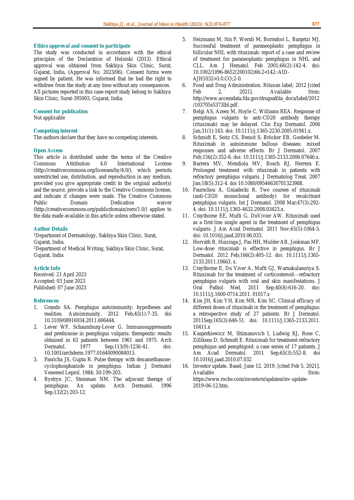


Markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

=== Sample 1: sample_00001 ===
Source image:


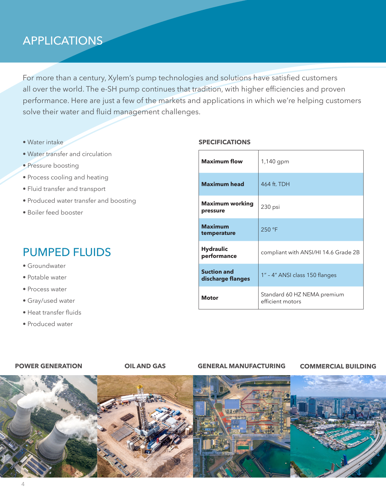


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Extracted figures: 1


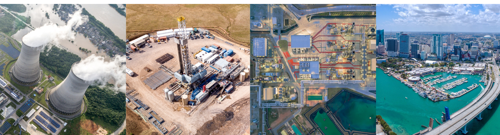

In [16]:
# Load and display samples after Extract
ds_extract = load_dataset_from_gcs(f"{GCS_OUTPUT_URI}/dataset")
display_samples(ds_extract, num_samples=2)

<a id="stage-2"></a>
## 🏷️ Stage 2: Describe

Generate captions for each extracted figure using vision-language inference. This stage also runs on GPU.

![Describe Stage](../assets/describe-cloudrun.png)


In [17]:
# Stage 2: Describe
# Updates dataset in place (same location as extract)
stage2_env = {
    "GCS_OUTPUT_URI": GCS_OUTPUT_URI,
    "GCS_INPUT_URI": f"{GCS_OUTPUT_URI}/dataset",
}

stage2_job = launch_stage("describe", stage2_env)

Deleting existing job: deepseek-ocr-describe
Creating job: deepseek-ocr-describe (GPU)
Launching describe stage...
Started job: deepseek-ocr-describe
Console: https://console.cloud.google.com/run/jobs/details/us-east4/deepseek-ocr-describe/executions?project=huggingface-ml


In [19]:
# Wait for Stage 2 to complete
# Estimated time: ~5-8 min for 1024 samples on L4 GPU
stage2_result = wait_for_job(stage2_job)
print(f"Describe stage completed: {stage2_result['status']}")


Waiting for job deepseek-ocr-describe...
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Running... (running=1)
  deepseek-ocr-describe: Completed ✓
Describe stage completed: Completed


In [ ]:
# Wait for describe to complete
# Estimated time: ~5-8 min for 1024 samples on L4 GPU
describe_result = wait_for_job("deepseek-ocr-describe")
print(f"Describe stage completed: {describe_result['status']}")


Dataset: 128 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


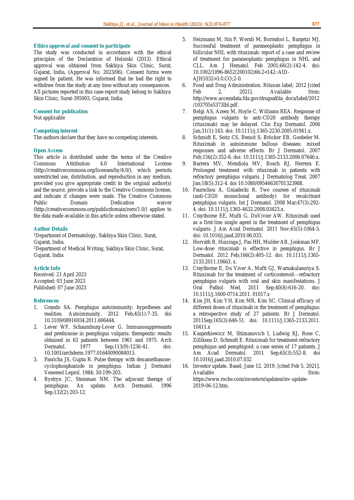


Markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

=== Sample 1: sample_00001 ===
Source image:


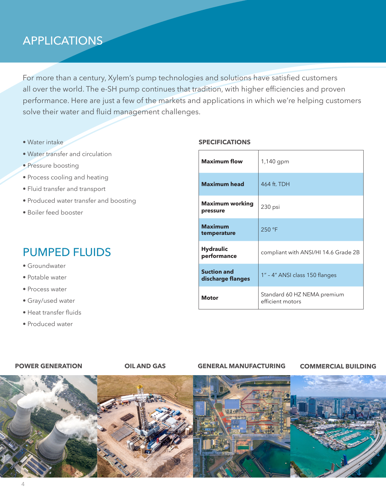


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Extracted figures: 1


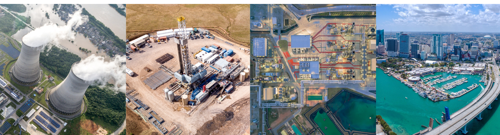

  📝 Description: even a part of the image that is not clear.The figure consists of four images, each depicting a different industrial facility. These images are part of a study on the transfer of visual concepts to te...



In [20]:
# Load and display samples after Describe
ds_describe = load_dataset_from_gcs(f"{GCS_OUTPUT_URI}/dataset")
display_samples(ds_describe, num_samples=2)

<a id="stage-3"></a>
## 🧩 Stage 3: Assemble

Combine the original Markdown with figure captions to produce the final enriched document. This stage runs **CPU-only** with a lightweight Docker image (no PyTorch/vLLM).

> 💡 Uses `Dockerfile.assemble` (~500MB) instead of the full vLLM image (~15GB), requiring only 4Gi memory.

![Assemble Stage](../assets/assemble-cloudrun.png)


In [46]:
# Stage 3: Assemble
# Updates dataset in place + saves final markdown files
stage3_env = {
    "GCS_OUTPUT_URI": GCS_OUTPUT_URI,
    "GCS_INPUT_URI": f"{GCS_OUTPUT_URI}/dataset",
}

stage3_job = launch_stage("assemble", stage3_env, use_gpu=False)  # CPU-only

Deleting existing job: deepseek-ocr-assemble
Creating job: deepseek-ocr-assemble (CPU-only)
Launching assemble stage...
Started job: deepseek-ocr-assemble
Console: https://console.cloud.google.com/run/jobs/details/us-east4/deepseek-ocr-assemble/executions?project=huggingface-ml


In [48]:
# Wait for Stage 3 to complete
# Estimated time: ~2-3 min (CPU-only, just text processing)
stage3_result = wait_for_job(stage3_job)
print(f"Assemble stage completed: {stage3_result['status']}")

check_job_status(stage3_job)


Recent executions for deepseek-ocr-assemble:
  deepseek-ocr-assemble-7dd87: SUCCEEDED ✓


Dataset: 128 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


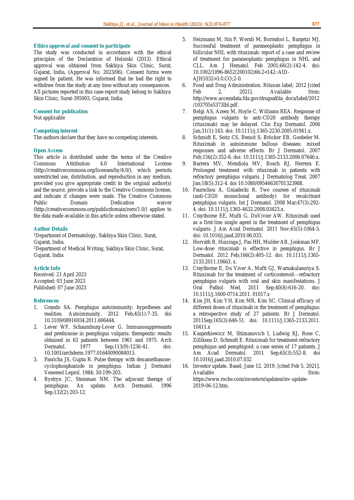


Markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

Final markdown preview (4756 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in thi

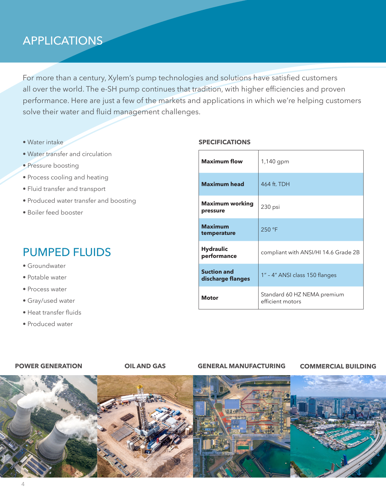


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Final markdown preview (4040 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Pr

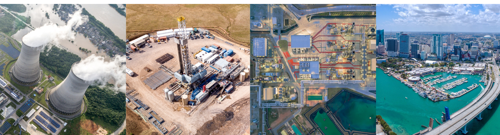

  📝 Description: even a part of the image that is not clear.The figure consists of four images, each depicting a different industrial facility. These images are part of a study on the transfer of visual concepts to te...



In [49]:
# Load and display final samples after Assemble
ds_final = load_dataset_from_gcs(f"{GCS_OUTPUT_URI}/dataset")
display_samples(ds_final, num_samples=2)

# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water transfer and boosting- Boiler feed booster  

## PUMPED FLUIDS  

- Groundwater- Potable water- Process water- Gray/used water- Heat transfer fluids- Produced water  

## SPECIFICATIONS  

<table><tr><td>Maximum flow</td><td>1,140 gpm</td></tr><tr><td>Maximum head</td><td>464 ft. TDH</td></tr><tr><td>Maximum working pressure</td><td>230 psi</td></tr><tr><td>Maximum temperature</td><td>250 °F</td></tr><tr><td>Hydraulic performance</td><td>compliant with ANSI/HI 14.6 Grade 2B</td></tr><tr><td>Suction and discharge flanges</td><td>1&quot; - 4&quot; ANSI class 150 flanges</td></tr><tr><td>Motor</td><td>Standard 60 HZ NEMA premium efficient motors</td></tr></table>  

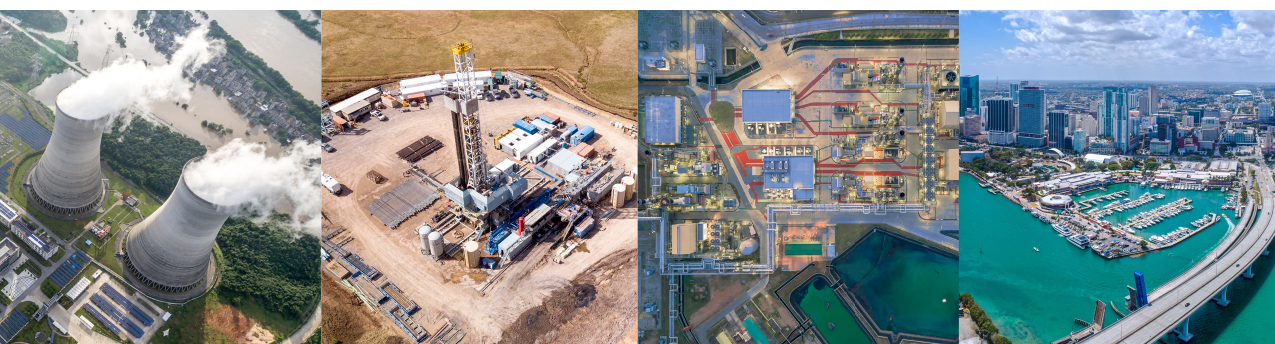

*Figure sample_00001_fig01: even a part of the image that is not clear.The figure consists of four images, each depicting a different industrial facility. These images are part of a study on the transfer of visual concepts to text, specifically focusing on the transfer of visual concepts from the COCO dataset to the Flickr dataset. The images are labeled as (a), (b), (c), and (d), and they represent the first, second, third, and fourth images, respectively.

1. **Image (a) - Power Plant**
   - This image shows a large power plant with two prominent cooling towers emitting steam. The facility is surrounded by greenery and infrastructure, indicating a significant industrial operation. The power plant is likely involved in generating electricity, as evidenced by the steam emissions.

2. **Image (b) - Chemical Plant**
   - The chemical plant depicted in this image features several large storage tanks and industrial buildings. The facility appears to be well-organized, with clear pathways and designated areas for different operations. The presence of multiple storage tanks suggests that the plant deals with large quantities of chemicals.

3. **Image (c) - Oil Refinery**
   - This image captures an oil refinery, characterized by numerous tanks, pipes, and industrial structures. The layout is complex, with various components working together to process crude oil. The presence of large storage tanks and extensive piping indicates the scale and complexity of operations within the refinery.

4. **Image (d) - Cruise Ship Terminal**
   - The cruise ship terminal shown in this image is situated near a body of water, likely a harbor or port. The terminal includes multiple docks and piers, with several cruise ships docked. The infrastructure is designed to handle the large vessels, with facilities for loading and unloading passengers and cargo.

**Analysis and Description:**
- **Power Plant (a)**: The power plant image highlights the industrial scale and the environmental impact of steam emissions. The cooling towers are a key feature, emphasizing the need for efficient cooling systems in such facilities.
- **Chemical Plant (b)**: The chemical plant image showcases the complexity and variety of operations within a chemical facility. The storage tanks are a critical component, and the overall layout suggests a well-planned and operational industrial site.
- **Oil Refinery (c)**: The oil refinery image illustrates the intricate network of industrial processes involved in oil refining. The presence of storage tanks and extensive piping indicates the handling of large volumes of oil, which is essential for the refinery's operations.
- **Cruise Ship Terminal (d)**: The*


In [50]:
# Display rendered markdown with images for sample 1
# This properly renders figure: URIs using images from extracted_figures column
display_markdown(ds_final[1])


<a id="cost-analysis"></a>
## 💰 Cost Analysis (Extract stage only)

| Metric | Value |
|--------|-------|
| 🖥️ **Hardware** | Nvidia L4 (24GB), 8 vCPU, 32 GiB RAM |
| ⚡ **Throughput** | ~39 pages/min |
| 🔄 **Concurrency** | 32 parallel requests |

**Pricing** ([Cloud Run GPU Pricing](https://cloud.google.com/run/pricing)):

| Resource | Rate | Per 1,024 pages |
|----------|------|-----------------|
| L4 GPU (no zonal redundancy) | $0.0001867/sec | $0.29 |
| CPU (8 vCPU) | $0.000018/vCPU-sec | $0.22 |
| Memory (32 GiB) | $0.000002/GiB-sec | $0.10 |
| **Total** | | **~$0.61** |

| Scale | ⏱️ Time | 💲 Cost |
|-------|------|------|
| 1,024 pages | ~26 min | ~$0.61 |
| 10,000 pages | ~4.3 hours | ~$6 |
| 100,000 pages | ~43 hours | ~$60 |

> 📄 **Note**: 1 page = 1 PDF page in these benchmarks.

> 💡 **Cost optimization**: Costs include GPU + CPU + Memory. Using [Committed Use Discounts](https://cloud.google.com/run/pricing) can reduce CPU/Memory costs by up to 46%. These costs can be further optimized by evaluating the best configuration based on your dataset characteristics.

<a id="cleanup"></a>
## 🧹 Cleanup

In [ ]:
# Delete jobs (optional)
def delete_job(job_name: str):
    from google.cloud.run_v2 import JobsClient
    client = JobsClient()
    job_path = f"projects/{PROJECT_ID}/locations/{REGION}/jobs/{job_name}"
    try:
        client.delete_job(name=job_path)
        print(f"Deleted job: {job_name}")
    except Exception as e:
        print(f"Could not delete {job_name}: {e}")

# Uncomment to delete:
# delete_job("deepseek-ocr-extract")
# delete_job("deepseek-ocr-describe")
# delete_job("deepseek-ocr-assemble")